In [203]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout, GlobalAvgPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Model, Input
from PIL import Image
%matplotlib widget

In [7]:
print("No. of GPUs Found: ", len(tf.config.list_physical_devices('GPU')))

No. of GPUs Found:  1


In [65]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [66]:
data_dir = "./dataset/"
train_dataset = image_dataset_from_directory(f"{data_dir}/train", batch_size=32, image_size=IMG_SIZE, shuffle=True, seed=42)
val_dataset = image_dataset_from_directory(f"{data_dir}/val", batch_size=32, image_size=IMG_SIZE, shuffle=True, seed=42)
test_dataset = image_dataset_from_directory(f"{data_dir}/test", batch_size=32, image_size=IMG_SIZE, shuffle=True, seed=42)

Found 1020 files belonging to 3 classes.
Found 804 files belonging to 3 classes.
Found 540 files belonging to 3 classes.


In [92]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [192]:
# Available Shapes [96, 128, 160, 192, 224]
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
print("Number of Layers: ", len(base_model.layers))

fine_tune_at = 100
print(f"Fine tuning from {fine_tune_at}th layer")
# Freezing every layer before fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of Layers:  154
Fine tuning from 100th layer


In [193]:
inputs = Input(shape=IMG_SHAPE)
X = preprocess_input(inputs)
X = base_model(X)
X = GlobalAvgPool2D()(X)
X = Dropout(0.25)(X)
outputs = Dense(units=3)(X)
RPSModel = Model(inputs=inputs, outputs=outputs, name="RockPaperScissorModel")

In [194]:
RPSModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [195]:
RPSModel.summary()

Model: "RockPaperScissorModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_32 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_32 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                    

In [ ]:
history = RPSModel.fit(train_dataset, epochs=50, validation_data=val_dataset)

In [198]:
RPSModel.evaluate(test_dataset)

17/17 [==============================] - 1s 31ms/step - loss: 0.5164 - accuracy: 0.8815


[0.5164235830307007, 0.8814814686775208]

In [199]:
RPSModel.save("./RPSModel_88.keras")

In [210]:
classes = train_dataset.class_names
print(classes)

['paper', 'rock', 'scissors']


1/1 [==============================] - 0s 8ms/step


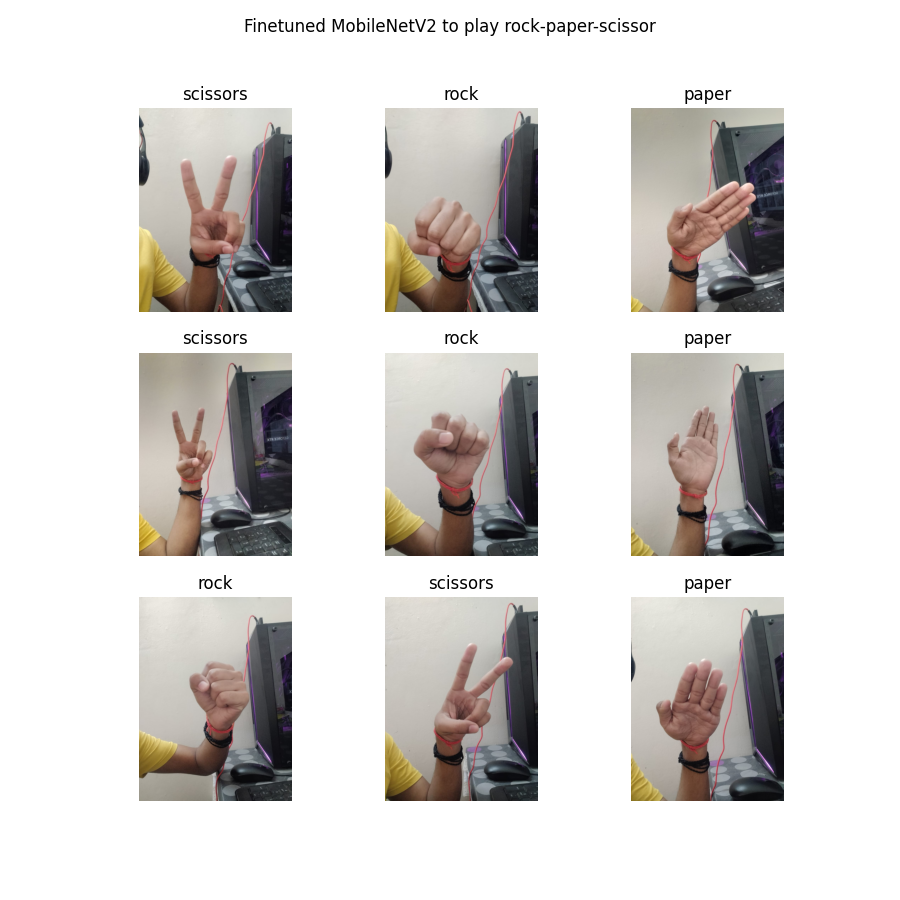

In [234]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
fig.suptitle("Finetuned MobileNetV2 to play rock-paper-scissor")
i = 1
for ax in axes.flat:
    original_img = plt.imread(f"./test_images/test{i}.jpg")
    img_resized = np.array(Image.fromarray(original_img).resize((224, 224)))
    ax.set_title(classes[np.argmax(tf.nn.softmax(RPSModel.predict(img_resized.reshape(1, 224, 224, 3))))])
    ax.imshow(original_img)
    ax.set_axis_off()
    i += 1
fig.savefig("./results.jpg", dpi=200)